In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn import svm

In [2]:
df = pd.read_pickle(r'D:\JupyterNotebook\DataProcess\preprocess_SWsastrawi_stemming.pkl')
dfNo = pd.read_pickle(r'D:\JupyterNotebook\DataProcess\preprocess_SWsastrawi_nostemming.pkl')

In [3]:
def split(strt,fnsh,df):
    X_test = df['text'].iloc[strt:fnsh]
    y_test = df['label'].iloc[strt:fnsh].astype('int')
    df = df.drop(df.index[strt:fnsh])
    X_train = df['text']
    y_train = df['label'].astype('int')    
    return X_train, X_test, y_train, y_test

In [6]:
def classifier(df,distance_name,k_neighbor):
    print("Nama distance=",distance_name)
    print("Jumlah K tetangga=",k_neighbor)
    spl = [0,108,216,324,432,540,648,756,864,972,1080]
    tempspl,acc_score = [],[]
    i = 0
    akurasimax=0
    while (i<len(spl)-1):
#         --------------Split-------------------
        if len(spl)-2 != len(tempspl):
            X_train, X_test, y_train, y_test = split(spl[i],spl[i+2],df)
            tempspl.append(spl[i])
    #   ketika array[i+2] == null (looping terakhir)
        elif (len(spl)-len(tempspl)) == 2:
    #       split last and first
            X_test1 = df['text'].iloc[spl[i]:spl[i+1]]
            y_test1 = df['label'].iloc[spl[i]:spl[i+1]].astype('int')
            X_test2 = df['text'].iloc[tempspl[0]:tempspl[1]]
            y_test2 = df['label'].iloc[tempspl[0]:tempspl[1]].astype('int')
    #       concat last and first
            X_test = pd.concat([X_test1, X_test2], axis=0)
            y_test = pd.concat([y_test1, y_test2], axis=0)
    #       split except last and first
            X_train = df['text'].iloc[tempspl[1]:tempspl[len(tempspl)-1]]
            y_train = df['label'].iloc[tempspl[1]:tempspl[len(tempspl)-1]].astype('int')
        
#         --------------Pembobotan TF-ID-------------------
        vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
#         vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

#         --------------CLasifier KNN-------------------        
        modelknn = KNeighborsClassifier(n_neighbors=k_neighbor, weights='uniform', metric=distance_name)
#         modelknn = svm.SVC()
        modelknn.fit(X_train,y_train)
        y_pred = modelknn.predict(X_test)
#         print(classification_report(y_test,y_pred))
        akurasi = modelknn.score(X_test, y_test)
        precision = precision_score(y_test,y_pred,average='weighted', labels=np.unique(y_pred))
        recall = recall_score(y_test, y_pred, average='weighted')
        f1score = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
        acc_score.append(akurasi)
        print("Fold ke-",i+1,"Akurasi =","{:.4f}".format(akurasi),
              "Precision =","{:.4f}".format(precision),
              "Recall =","{:.4f}".format(recall),
              "F1-Score =","{:.4f}".format(f1score))
        if (akurasi >= akurasimax):
            akurasimax = akurasi
            foldke = i+1
        i+=1
    avg_acc_score = sum(acc_score)/10
    print('Avg accuracy : {}'.format(avg_acc_score))
    print("Akurasi terbaik adalah",akurasimax,"pada fold ke-",foldke)
    print("------------------------------------")
    return akurasimax

Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
Fold ke- 1 Akurasi = 0.1065 Precision = 0.6810 Recall = 0.1065 F1-Score = 0.1123
Fold ke- 2 Akurasi = 0.6204 Precision = 0.6217 Recall = 0.6204 F1-Score = 0.6086
Fold ke- 3 Akurasi = 0.6157 Precision = 0.6255 Recall = 0.6157 F1-Score = 0.6087
Fold ke- 4 Akurasi = 0.1806 Precision = 0.8593 Recall = 0.1806 F1-Score = 0.2140
Fold ke- 5 Akurasi = 0.2130 Precision = 0.8440 Recall = 0.2130 F1-Score = 0.2956
Fold ke- 6 Akurasi = 0.1991 Precision = 0.8667 Recall = 0.1991 F1-Score = 0.2364
Fold ke- 7 Akurasi = 0.1991 Precision = 0.7966 Recall = 0.1991 F1-Score = 0.2229
Fold ke- 8 Akurasi = 0.1852 Precision = 0.6268 Recall = 0.1852 F1-Score = 0.2019
Fold ke- 9 Akurasi = 0.1806 Precision = 0.6864 Recall = 0.1806 F1-Score = 0.2303
Fold ke- 10 Akurasi = 0.1435 Precision = 0.7510 Recall = 0.1435 F1-Score = 0.1938
Avg accuracy : 0.26435185185185184
Akurasi terbaik adalah 0.6203703703703703 pada fold ke- 2
----------------------------------

Fold ke- 3 Akurasi = 0.7083 Precision = 0.7155 Recall = 0.7083 F1-Score = 0.7060
Fold ke- 4 Akurasi = 0.7546 Precision = 0.7800 Recall = 0.7546 F1-Score = 0.7546
Fold ke- 5 Akurasi = 0.7593 Precision = 0.7919 Recall = 0.7593 F1-Score = 0.7592
Fold ke- 6 Akurasi = 0.8148 Precision = 0.8469 Recall = 0.8148 F1-Score = 0.8154
Fold ke- 7 Akurasi = 0.7731 Precision = 0.8005 Recall = 0.7731 F1-Score = 0.7699
Fold ke- 8 Akurasi = 0.7546 Precision = 0.7824 Recall = 0.7546 F1-Score = 0.7528
Fold ke- 9 Akurasi = 0.7685 Precision = 0.7996 Recall = 0.7685 F1-Score = 0.7660
Fold ke- 10 Akurasi = 0.7593 Precision = 0.7753 Recall = 0.7593 F1-Score = 0.7587
Avg accuracy : 0.737037037037037
Akurasi terbaik adalah 0.8148148148148148 pada fold ke- 6
------------------------------------
Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 19
Fold ke- 1 Akurasi = 0.6528 Precision = 0.6712 Recall = 0.6528 F1-Score = 0.6465
Fold ke- 2 Akurasi = 0.6389 Precision = 0.6611 Recall = 0.6389 F1-Score = 0.630

Fold ke- 6 Akurasi = 0.1435 Precision = 0.8156 Recall = 0.1435 F1-Score = 0.1542
Fold ke- 7 Akurasi = 0.1389 Precision = 0.7985 Recall = 0.1389 F1-Score = 0.1885
Fold ke- 8 Akurasi = 0.1389 Precision = 0.7611 Recall = 0.1389 F1-Score = 0.1681
Fold ke- 9 Akurasi = 0.1296 Precision = 0.7745 Recall = 0.1296 F1-Score = 0.1648
Fold ke- 10 Akurasi = 0.1111 Precision = 0.7366 Recall = 0.1111 F1-Score = 0.1284
Avg accuracy : 0.12407407407407407
Akurasi terbaik adalah 0.14351851851851852 pada fold ke- 6
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 3
Fold ke- 1 Akurasi = 0.1111 Precision = 0.7172 Recall = 0.1111 F1-Score = 0.1528
Fold ke- 2 Akurasi = 0.1991 Precision = 0.6213 Recall = 0.1991 F1-Score = 0.2118
Fold ke- 3 Akurasi = 0.3241 Precision = 0.7005 Recall = 0.3241 F1-Score = 0.3739
Fold ke- 4 Akurasi = 0.1852 Precision = 0.7790 Recall = 0.1852 F1-Score = 0.2461
Fold ke- 5 Akurasi = 0.2546 Precision = 0.8305 Recall = 0.2546 F1-Score = 0.3

Fold ke- 9 Akurasi = 0.3148 Precision = 0.7227 Recall = 0.3148 F1-Score = 0.3584
Fold ke- 10 Akurasi = 0.2824 Precision = 0.7375 Recall = 0.2824 F1-Score = 0.2669
Avg accuracy : 0.2671296296296296
Akurasi terbaik adalah 0.3333333333333333 pada fold ke- 6
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 19
Fold ke- 1 Akurasi = 0.1806 Precision = 0.6190 Recall = 0.1806 F1-Score = 0.2932
Fold ke- 2 Akurasi = 0.1806 Precision = 0.6376 Recall = 0.1806 F1-Score = 0.2962
Fold ke- 3 Akurasi = 0.2500 Precision = 0.6538 Recall = 0.2500 F1-Score = 0.3101
Fold ke- 4 Akurasi = 0.3009 Precision = 0.5577 Recall = 0.3009 F1-Score = 0.4055
Fold ke- 5 Akurasi = 0.3056 Precision = 0.5855 Recall = 0.3056 F1-Score = 0.4093
Fold ke- 6 Akurasi = 0.3241 Precision = 0.6640 Recall = 0.3241 F1-Score = 0.4421
Fold ke- 7 Akurasi = 0.3241 Precision = 0.7678 Recall = 0.3241 F1-Score = 0.4060
Fold ke- 8 Akurasi = 0.2917 Precision = 0.7086 Recall = 0.2917 F1-Score = 0.38

Fold ke- 1 Akurasi = 0.5231 Precision = 0.6080 Recall = 0.5231 F1-Score = 0.5158
Fold ke- 2 Akurasi = 0.6157 Precision = 0.6386 Recall = 0.6157 F1-Score = 0.6149
Fold ke- 3 Akurasi = 0.6574 Precision = 0.6739 Recall = 0.6574 F1-Score = 0.6608
Fold ke- 4 Akurasi = 0.7269 Precision = 0.7539 Recall = 0.7269 F1-Score = 0.7258
Fold ke- 5 Akurasi = 0.7778 Precision = 0.8059 Recall = 0.7778 F1-Score = 0.7732
Fold ke- 6 Akurasi = 0.7685 Precision = 0.7975 Recall = 0.7685 F1-Score = 0.7586
Fold ke- 7 Akurasi = 0.7593 Precision = 0.8100 Recall = 0.7593 F1-Score = 0.7504
Fold ke- 8 Akurasi = 0.7130 Precision = 0.7335 Recall = 0.7130 F1-Score = 0.7097
Fold ke- 9 Akurasi = 0.6944 Precision = 0.7177 Recall = 0.6944 F1-Score = 0.6919
Fold ke- 10 Akurasi = 0.6713 Precision = 0.7113 Recall = 0.6713 F1-Score = 0.6692
Avg accuracy : 0.6907407407407407
Akurasi terbaik adalah 0.7777777777777778 pada fold ke- 5
------------------------------------
Dengan Stemming
Nama distance= minkowski
Jumlah K tetangga= 

Fold ke- 4 Akurasi = 0.7269 Precision = 0.7540 Recall = 0.7269 F1-Score = 0.7263
Fold ke- 5 Akurasi = 0.7639 Precision = 0.8012 Recall = 0.7639 F1-Score = 0.7632
Fold ke- 6 Akurasi = 0.8102 Precision = 0.8458 Recall = 0.8102 F1-Score = 0.8101
Fold ke- 7 Akurasi = 0.7731 Precision = 0.8015 Recall = 0.7731 F1-Score = 0.7708
Fold ke- 8 Akurasi = 0.7593 Precision = 0.7857 Recall = 0.7593 F1-Score = 0.7583
Fold ke- 9 Akurasi = 0.7778 Precision = 0.8062 Recall = 0.7778 F1-Score = 0.7748
Fold ke- 10 Akurasi = 0.7500 Precision = 0.7694 Recall = 0.7500 F1-Score = 0.7489
Avg accuracy : 0.7333333333333333
Akurasi terbaik adalah 0.8101851851851852 pada fold ke- 6
------------------------------------
Dengan Stemming
Nama distance= minkowski
Jumlah K tetangga= 21
Fold ke- 1 Akurasi = 0.6481 Precision = 0.6688 Recall = 0.6481 F1-Score = 0.6422
Fold ke- 2 Akurasi = 0.6435 Precision = 0.6765 Recall = 0.6435 F1-Score = 0.6355
Fold ke- 3 Akurasi = 0.6898 Precision = 0.7012 Recall = 0.6898 F1-Score = 0.68

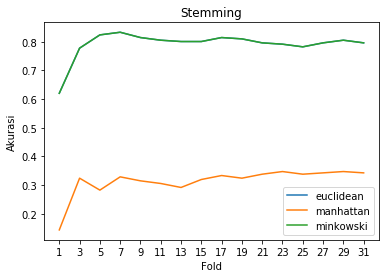

Tanpa Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
Fold ke- 1 Akurasi = 0.1019 Precision = 0.8170 Recall = 0.1019 F1-Score = 0.1155
Fold ke- 2 Akurasi = 0.6065 Precision = 0.6089 Recall = 0.6065 F1-Score = 0.6003
Fold ke- 3 Akurasi = 0.5880 Precision = 0.6034 Recall = 0.5880 F1-Score = 0.5836
Fold ke- 4 Akurasi = 0.1481 Precision = 0.8433 Recall = 0.1481 F1-Score = 0.1702
Fold ke- 5 Akurasi = 0.1667 Precision = 0.8864 Recall = 0.1667 F1-Score = 0.2301
Fold ke- 6 Akurasi = 0.1713 Precision = 0.8325 Recall = 0.1713 F1-Score = 0.2107
Fold ke- 7 Akurasi = 0.1713 Precision = 0.7665 Recall = 0.1713 F1-Score = 0.1958
Fold ke- 8 Akurasi = 0.1667 Precision = 0.8091 Recall = 0.1667 F1-Score = 0.1905
Fold ke- 9 Akurasi = 0.1574 Precision = 0.8030 Recall = 0.1574 F1-Score = 0.2098
Fold ke- 10 Akurasi = 0.1296 Precision = 0.7369 Recall = 0.1296 F1-Score = 0.1838
Avg accuracy : 0.24074074074074076
Akurasi terbaik adalah 0.6064814814814815 pada fold ke- 2
-----------------------------------

Fold ke- 3 Akurasi = 0.7222 Precision = 0.7304 Recall = 0.7222 F1-Score = 0.7222
Fold ke- 4 Akurasi = 0.7870 Precision = 0.8065 Recall = 0.7870 F1-Score = 0.7877
Fold ke- 5 Akurasi = 0.7824 Precision = 0.8127 Recall = 0.7824 F1-Score = 0.7825
Fold ke- 6 Akurasi = 0.8194 Precision = 0.8584 Recall = 0.8194 F1-Score = 0.8234
Fold ke- 7 Akurasi = 0.7917 Precision = 0.8255 Recall = 0.7917 F1-Score = 0.7896
Fold ke- 8 Akurasi = 0.7870 Precision = 0.8131 Recall = 0.7870 F1-Score = 0.7845
Fold ke- 9 Akurasi = 0.7731 Precision = 0.8043 Recall = 0.7731 F1-Score = 0.7686
Fold ke- 10 Akurasi = 0.7546 Precision = 0.7718 Recall = 0.7546 F1-Score = 0.7476
Avg accuracy : 0.7550925925925926
Akurasi terbaik adalah 0.8194444444444444 pada fold ke- 6
------------------------------------
Tanpa Stemming
Nama distance= euclidean
Jumlah K tetangga= 19
Fold ke- 1 Akurasi = 0.6852 Precision = 0.6929 Recall = 0.6852 F1-Score = 0.6729
Fold ke- 2 Akurasi = 0.6852 Precision = 0.7010 Recall = 0.6852 F1-Score = 0.673

Fold ke- 6 Akurasi = 0.1296 Precision = 0.8431 Recall = 0.1296 F1-Score = 0.1310
Fold ke- 7 Akurasi = 0.1296 Precision = 0.8221 Recall = 0.1296 F1-Score = 0.1661
Fold ke- 8 Akurasi = 0.1343 Precision = 0.8697 Recall = 0.1343 F1-Score = 0.1797
Fold ke- 9 Akurasi = 0.1204 Precision = 0.6812 Recall = 0.1204 F1-Score = 0.1586
Fold ke- 10 Akurasi = 0.1019 Precision = 0.6171 Recall = 0.1019 F1-Score = 0.1137
Avg accuracy : 0.11296296296296297
Akurasi terbaik adalah 0.13425925925925927 pada fold ke- 8
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 3
Fold ke- 1 Akurasi = 0.0972 Precision = 0.7711 Recall = 0.0972 F1-Score = 0.1179
Fold ke- 2 Akurasi = 0.1852 Precision = 0.6255 Recall = 0.1852 F1-Score = 0.1899
Fold ke- 3 Akurasi = 0.2500 Precision = 0.6378 Recall = 0.2500 F1-Score = 0.2779
Fold ke- 4 Akurasi = 0.1528 Precision = 0.6988 Recall = 0.1528 F1-Score = 0.1972
Fold ke- 5 Akurasi = 0.2083 Precision = 0.8370 Recall = 0.2083 F1-Score = 0.31

Fold ke- 9 Akurasi = 0.2407 Precision = 0.6858 Recall = 0.2407 F1-Score = 0.3050
Fold ke- 10 Akurasi = 0.2269 Precision = 0.5759 Recall = 0.2269 F1-Score = 0.2162
Avg accuracy : 0.21296296296296297
Akurasi terbaik adalah 0.26851851851851855 pada fold ke- 7
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 19
Fold ke- 1 Akurasi = 0.1713 Precision = 0.6314 Recall = 0.1713 F1-Score = 0.2560
Fold ke- 2 Akurasi = 0.1250 Precision = 0.6461 Recall = 0.1250 F1-Score = 0.2453
Fold ke- 3 Akurasi = 0.2222 Precision = 0.5603 Recall = 0.2222 F1-Score = 0.2819
Fold ke- 4 Akurasi = 0.2176 Precision = 0.5412 Recall = 0.2176 F1-Score = 0.3061
Fold ke- 5 Akurasi = 0.2361 Precision = 0.7629 Recall = 0.2361 F1-Score = 0.3898
Fold ke- 6 Akurasi = 0.2454 Precision = 0.6796 Recall = 0.2454 F1-Score = 0.4108
Fold ke- 7 Akurasi = 0.2917 Precision = 0.7063 Recall = 0.2917 F1-Score = 0.4769
Fold ke- 8 Akurasi = 0.2407 Precision = 0.7260 Recall = 0.2407 F1-Score = 0.3

Fold ke- 1 Akurasi = 0.5694 Precision = 0.6415 Recall = 0.5694 F1-Score = 0.5521
Fold ke- 2 Akurasi = 0.6111 Precision = 0.6332 Recall = 0.6111 F1-Score = 0.6124
Fold ke- 3 Akurasi = 0.6713 Precision = 0.6887 Recall = 0.6713 F1-Score = 0.6724
Fold ke- 4 Akurasi = 0.7269 Precision = 0.7438 Recall = 0.7269 F1-Score = 0.7238
Fold ke- 5 Akurasi = 0.7870 Precision = 0.8142 Recall = 0.7870 F1-Score = 0.7860
Fold ke- 6 Akurasi = 0.7500 Precision = 0.7737 Recall = 0.7500 F1-Score = 0.7415
Fold ke- 7 Akurasi = 0.7500 Precision = 0.7984 Recall = 0.7500 F1-Score = 0.7416
Fold ke- 8 Akurasi = 0.7176 Precision = 0.7451 Recall = 0.7176 F1-Score = 0.7129
Fold ke- 9 Akurasi = 0.6759 Precision = 0.6934 Recall = 0.6759 F1-Score = 0.6719
Fold ke- 10 Akurasi = 0.6620 Precision = 0.6971 Recall = 0.6620 F1-Score = 0.6560
Avg accuracy : 0.6921296296296295
Akurasi terbaik adalah 0.7870370370370371 pada fold ke- 5
------------------------------------
Tanpa Stemming
Nama distance= minkowski
Jumlah K tetangga= 5

Fold ke- 4 Akurasi = 0.7778 Precision = 0.7967 Recall = 0.7778 F1-Score = 0.7775
Fold ke- 5 Akurasi = 0.7685 Precision = 0.8046 Recall = 0.7685 F1-Score = 0.7684
Fold ke- 6 Akurasi = 0.8148 Precision = 0.8481 Recall = 0.8148 F1-Score = 0.8158
Fold ke- 7 Akurasi = 0.7824 Precision = 0.8141 Recall = 0.7824 F1-Score = 0.7793
Fold ke- 8 Akurasi = 0.7778 Precision = 0.8066 Recall = 0.7778 F1-Score = 0.7755
Fold ke- 9 Akurasi = 0.7731 Precision = 0.8076 Recall = 0.7731 F1-Score = 0.7680
Fold ke- 10 Akurasi = 0.7454 Precision = 0.7691 Recall = 0.7454 F1-Score = 0.7391
Avg accuracy : 0.7509259259259259
Akurasi terbaik adalah 0.8148148148148148 pada fold ke- 6
------------------------------------
Tanpa Stemming
Nama distance= minkowski
Jumlah K tetangga= 21
Fold ke- 1 Akurasi = 0.6991 Precision = 0.7177 Recall = 0.6991 F1-Score = 0.6856
Fold ke- 2 Akurasi = 0.6944 Precision = 0.7152 Recall = 0.6944 F1-Score = 0.6818
Fold ke- 3 Akurasi = 0.6991 Precision = 0.7085 Recall = 0.6991 F1-Score = 0.697

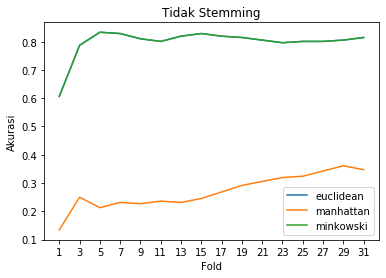

Lama Proses 514.5298566818237 seconds
Wall time: 8min 34s


In [8]:
%%time
start_time = time.time()
dfcount = [df,dfNo]
distancecount = ['euclidean','manhattan','minkowski']
kcount = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
for x in range(2):
    arrd1 = []
    arrd2 = []
    arrd3 = []
    for y in range(len(distancecount)):
        maxresult = []
        for z in range(len(kcount)):
            if x==0:
                print('Dengan Stemming')
            else:
                print('Tanpa Stemming')
            tempmax= classifier(dfcount[x],distancecount[y],kcount[z])
            maxresult.append(tempmax)
            if y==0:
                arrd1.append(tempmax)
            elif y==1:
                arrd2.append(tempmax)
            elif y==2:
                arrd3.append(tempmax)
    plt.plot(kcount, arrd1, label = "euclidean")
    plt.plot(kcount, arrd2, label = "manhattan")
    plt.plot(kcount, arrd3, label = "minkowski")
    plt.xticks(kcount)
    if x==0:
        plt.title("Stemming")
    else:
        plt.title("Tidak Stemming")
    plt.xlabel('Fold')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.pause(0.05)
plt.show
print("Lama Proses %s seconds" % (time.time() - start_time))